In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
import math
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)



### Loading the Data into train and test

In [21]:
# Load the dataset
data = pd.read_csv('./data/surgery_data.csv', index_col=0)

# Split the data into features (X) and target variable (y)
X = data
y = data


# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)


In [22]:
X_train.describe()

,Surgery Type,Anesthesia Type,Age,BMI,DoctorID,AnaesthetistID,Duration in Minutes
count,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000,7200.000000
mean,1.990972,0.496528,49.489028,24.442222,558630.596250,549441.338056,114.568056
std,1.414332,0.500023,9.969276,5.048947,257820.075509,257793.263140,54.473408
min,0.000000,0.000000,13.000000,7.000000,100097.000000,100162.000000,15.000000
25%,1.000000,0.000000,43.000000,21.000000,336513.250000,328387.250000,59.000000
50%,2.000000,0.000000,50.000000,24.000000,563976.000000,547798.000000,131.000000
75%,3.000000,1.000000,56.000000,28.000000,778242.000000,770507.000000,161.000000
max,4.000000,1.000000,88.000000,43.000000,999995.000000,999907.000000,232.000000


##### Search for feature with too much missing value

In [23]:
df = X_train
df2 = df[[column for column in df if df[column].count() / len(df) >= 0.3]]
print("List of dropped columns:", end=" ")
for c in df.columns:
    if c not in df2.columns:
        print(c, end=", ")
print('\n')
df = df2

List of dropped columns: 



In [24]:
cat_cols = ['Surgery Type', 'Anesthesia Type', 'DoctorID', 'AnaesthetistID']
num_cols = ['Age', 'BMI']
target_col = 'Duration in Minutes'

In [40]:
print(data['DoctorID'].value_counts().value_counts())
print(data['AnaesthetistID'].value_counts().value_counts())

1    9892
2      54
Name: DoctorID, dtype: int64
1    9887
2      55
3       1
Name: AnaesthetistID, dtype: int64


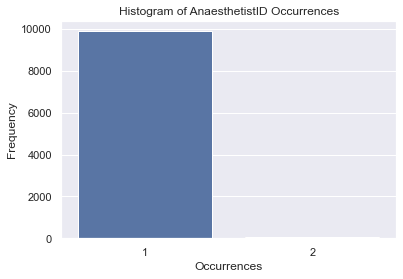

In [54]:
anaesthetist_counts = data['DoctorID'].value_counts()#.value_counts()
sns.countplot(x=anaesthetist_counts.index, data=anaesthetist_counts)
plt.xlabel('Occurrences')
plt.ylabel('Frequency')
plt.title('Histogram of AnaesthetistID Occurrences')
plt.show()

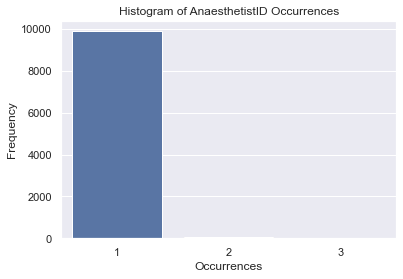

In [55]:
anaesthetist_counts = data['AnaesthetistID'].value_counts()#.value_counts()
sns.countplot(x=anaesthetist_counts.index, data=anaesthetist_counts)
plt.xlabel('Occurrences')
plt.ylabel('Frequency')
plt.title('Histogram of AnaesthetistID Occurrences')
plt.show()

## Drop redundant features
It appears that we have limited information available in these two columns. The 'DoctorID' column has only a few unique doctors, with each doctor appearing only twice. Similarly, the 'AnaesthetistID' column has only one unique anaesthetist who appears three times. Consequently, these columns may not provide sufficient data for learning meaningful patterns or relationships in some models. 

In [27]:
dropped_train = X_train.drop(['DoctorID', 'AnaesthetistID'], axis=1)
dropped_test = X_test.drop(['DoctorID', 'AnaesthetistID'], axis=1)
dropped_val = X_val.drop(['DoctorID', 'AnaesthetistID'], axis=1)
linreg_catcols = ['Surgery Type', 'Anesthesia Type']

In [28]:
def data_preprocess(data, cat_cols, num_cols, target_col):
    encoded_categorical, encoded_numerical, encoder_pred = None,None,None
    encoded_numerical = StandardScaler().fit(data[num_cols].values)
    encoded_categorical = OneHotEncoder(sparse=False).fit(data[cat_cols].values)
    encoder_pred = StandardScaler().fit(data[target_col].values.reshape(-1, 1))
    transformed_categorical = encoded_categorical.transform(data[cat_cols].values)
    transformed_numerical = encoded_numerical.transform(data[num_cols].values)
    target = encoder_pred.transform(data[target_col].values.reshape(-1, 1))
    return np.hstack([transformed_categorical, transformed_numerical]), target.ravel(), (encoded_categorical, encoded_numerical, encoder_pred)

In [29]:
x_train, y_train, encoders = data_preprocess(dropped_train, linreg_catcols, num_cols, target_col)
x_val, y_val, _ = data_preprocess(dropped_val, linreg_catcols, num_cols, target_col)
x_test, y_test, _ = data_preprocess(dropped_test, linreg_catcols, num_cols, target_col)

## Model Selection

In [30]:
models = [
  ('LR', LinearRegression()),
  ('Ridge', Ridge()),
  ('Lasso', Lasso()),
  ('BR', BayesianRidge()),
  ('KNR', KNeighborsRegressor()),
  ('DT', DecisionTreeRegressor()),
  ('RF', RandomForestRegressor()),
  ('GB', GradientBoostingRegressor()),
  ('AB', AdaBoostRegressor()),
  ('VR', VotingRegressor(estimators=
                            [
                              ('gb', GradientBoostingRegressor()),
                              ('rf', RandomForestRegressor()),
                              ('dt', DecisionTreeRegressor()), 
                            ]))

]

In [31]:
def fit_model(model, x_train, y_train):
  model.fit(x_train, y_train)

# Fitting al the given models
for (name, model) in models:
  fit_model(model, x_train, y_train)

In [32]:
def calc_metrics(fitted_model, x_test, y_test):
  y_pred = fitted_model.predict(x_test)
  y_test_decoded = encoders[2].inverse_transform(y_test.reshape(-1, 1))
  y_pred_decoded = encoders[2].inverse_transform(y_pred.reshape(-1, 1))
  mae = mean_absolute_error(y_test_decoded, y_pred_decoded)
  mse = math.sqrt(mean_squared_error(y_test_decoded, y_pred_decoded))
  return (mae, mse)

In [33]:
model_names = [model_name for (model_name, model) in models]
models_mae = []
models_mse = []

for (model_name, model) in models:
  (mae, mse) = calc_metrics(model, x_test, y_test)
  models_mae.append(mae)
  models_mse.append(mse)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


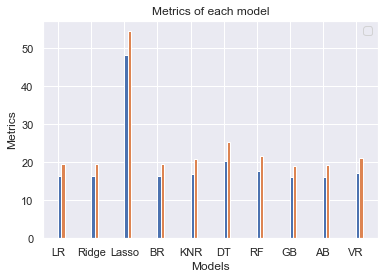

[16.287271321663603, 16.285203104591968, 48.310816106082335, 16.284322551895563, 17.0047456259182, 20.242663353361436, 17.688601559062125, 16.007569183720125, 16.052700597584312, 17.253957367533104]


In [56]:
X_axis = np.arange(len(model_names))
  
plt.bar(X_axis + 0.05, models_mae, 0.1)
plt.bar(X_axis + 0.15, models_mse, 0.1)
#plt.bar(X_axis + 0.25, models_mcc, 0.1)

plt.xticks(X_axis, model_names)
plt.xlabel("Models")
plt.ylabel("Metrics")
plt.title("Metrics of each model")
plt.legend()
plt.show()

print(models_mae)

### Hyper-Parameters Optimization


In [35]:
model = GradientBoostingRegressor()

print('GB hyperparams:')
model.get_params()

GB hyperparams:


{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [36]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.1, 0.05, 0.01],
    'max_depth': [3, 4, 5, 7, 10]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_search.fit(x_val, y_val)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters: ", best_params)
print("Best Score: ", best_score)

Best Parameters:  {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best Score:  0.8763543259387129


In [37]:
_n_estimators =  grid_search.best_params_["n_estimators"]
_learning_rate =  grid_search.best_params_["learning_rate"]
_max_depth =  grid_search.best_params_["max_depth"]

_GB = GradientBoostingRegressor(n_estimators=_n_estimators, learning_rate=_learning_rate,  max_depth=_max_depth, random_state=42).fit(x_train, y_train)
y_pred = _GB.predict(x_test)
y_test_decoded = encoders[2].inverse_transform(y_test.reshape(-1, 1))
y_pred_decoded = encoders[2].inverse_transform(y_pred.reshape(-1, 1))
mae = mean_absolute_error(y_test_decoded, y_pred_decoded)
print("The lowest mean absolute error we were able to give: ", mae)

The lowest mean absolute error we were able to give:  16.029052107448898


### Comparing predicted values with the actual values

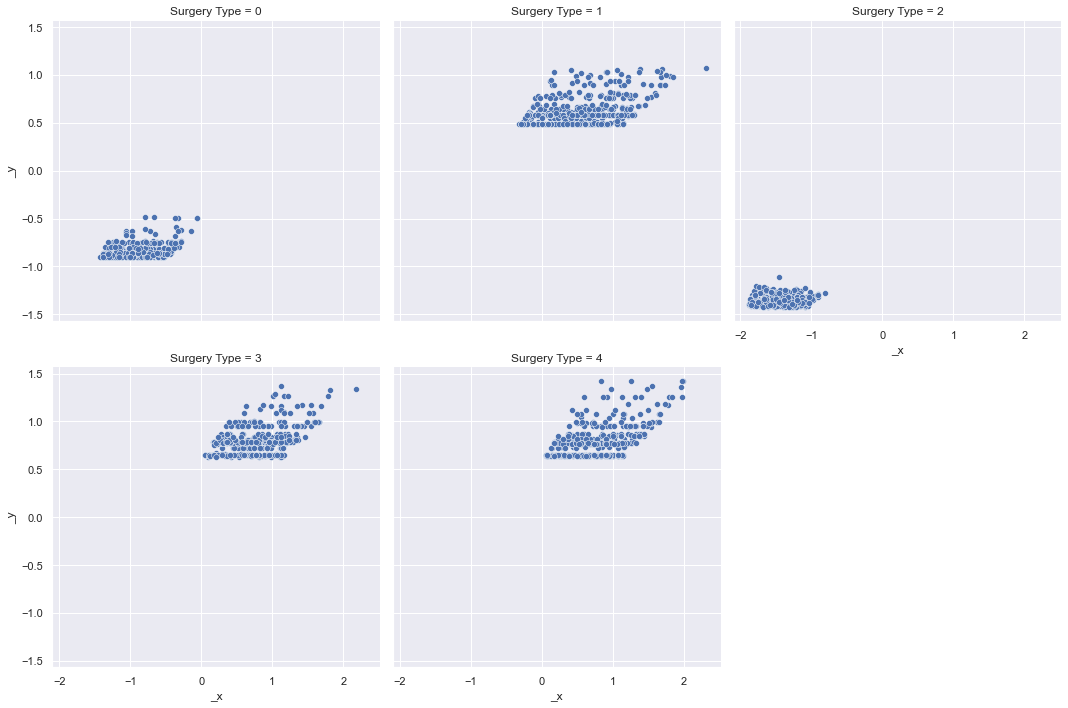

In [52]:
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)
sns.relplot(x=y_test, y=y_pred, col=X_test['Surgery Type'], col_wrap=3)